<a href="https://colab.research.google.com/github/HadrienBd/Natural_Language_Processing/blob/main/nlp_project_bernard_hadrien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment analysis**

## Sommaire

- [Data preparation](#1)
    - [Importing libraries](#2)
    - [Importing data](#3)
    - [Cleaning data](#4)
    - [Displaying vocabulary](#5)
- [Model preparation](#6)
    - [Shuffle dataset](#6)
    - [Tokenization](#8)
    - [Word embedding](#9)
- [Model training](#10)
    - [Long Short-Term Memory](#10)
    - [Training](#11)
- [Model evaluation](#12)
    - [Learning Curve of loss and accuracy](#12)
    - [Confusion matrix](#13)
    - [Classification scores](#14)
    - [Saving model](#15)
- [Testing our model](#16)
    - [Pipeline](#16)



<a name='1'></a>
##Data prepatation

<a name='2'></a>
###First step : Importing libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<a name='3'></a>
###Importing data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('gdrive/MyDrive/NLP_DATA/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1")
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'original_tweet']

In [4]:
df.head()

,sentiment,id,date,query,user_id,original_tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
#Remove everything execpt tweet content
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [6]:
#We change label in sentiment : 0 -> Negative 4 -> Positive
label_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return label_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,original_tweet
0,Negative,is upset that he can't update his Facebook by ...
1,Negative,@Kenichan I dived many times for the ball. Man...
2,Negative,my whole body feels itchy and like its on fire
3,Negative,"@nationwideclass no, it's not behaving at all...."
4,Negative,@Kwesidei not the whole crew


Display data distribution

Text(0.5, 1.0, 'Sentiment Data Distribution')

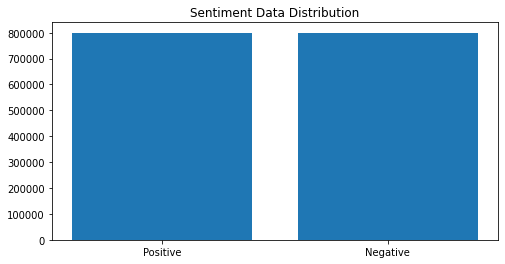

In [7]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

<a name='4'></a>
###Cleaning data

In [8]:
stop_words = stopwords.words('english')

stemmer = EnglishStemmer()

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def clean_data(text, stem=False, stop=False):
  text = re.sub("n't", 'nt', str(text).lower()).strip()
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if stop:
      if token not in stop_words:
        if stem:
          tokens.append(stemmer.stem(token))
        else:
          tokens.append(token)  
    else:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)     
  return " ".join(tokens)

In [10]:
df['text'] = df.original_tweet.apply(lambda x: clean_data(x))

In [11]:
df['text_stem'] = df.original_tweet.apply(lambda x: clean_data(x, True))

In [12]:
df['text_stop'] = df.original_tweet.apply(lambda x: clean_data(x, False, True))

In [13]:
df['text_stem_stop'] = df.original_tweet.apply(lambda x: clean_data(x, True, True))

In [14]:
df.head()

,sentiment,original_tweet,text,text_stem,text_stop,text_stem_stop
0,Negative,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...,is upset that he cant updat his facebook by te...,upset cant update facebook texting might cry r...,upset cant updat facebook text might cri resul...
1,Negative,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,i dive mani time for the ball manag to save 50...,dived many times ball managed save 50 rest go ...,dive mani time ball manag save 50 rest go bound
2,Negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole bodi feel itchi and like it on fire,whole body feels itchy like fire,whole bodi feel itchi like fire
3,Negative,"@nationwideclass no, it's not behaving at all....",no it s not behaving at all i m mad why am i h...,no it s not behav at all i m mad whi am i here...,behaving mad cant see,behav mad cant see
4,Negative,@Kwesidei not the whole crew,not the whole crew,not the whole crew,whole crew,whole crew


<a name='5'></a>
###Displaying vocabulary

In [15]:
positive_words = []
for tweet in df[df.sentiment == 'Positive'].text_stem_stop :
  for word in tweet.split():
    positive_words.append(word)

positive_words_freq = dict()
for w in positive_words:
    if w not in positive_words_freq.keys():
      positive_words_freq[w] = 1
    else:
      positive_words_freq[w] += 1

positive_words_freq = dict(reversed(sorted(positive_words_freq.items(), key=lambda item: item[1])))
print({k: positive_words_freq[k] for k in list(positive_words_freq)[:10]})

{'good': 62841, 'love': 60863, 'go': 59282, 'day': 55824, 'thank': 51066, 'get': 49205, 'quot': 46973, 'like': 40563, 'lol': 36248, 'time': 34592}


In [16]:
negative_words = []
for tweet in df[df.sentiment == 'Negative'].text_stem_stop :
  for word in tweet.split():
    negative_words.append(word)

negative_words_freq = dict()
for w in negative_words:
    if w not in negative_words_freq.keys():
      negative_words_freq[w] = 1
    else:
      negative_words_freq[w] += 1

negative_words_freq = dict(reversed(sorted(negative_words_freq.items(), key=lambda item: item[1])))
print({k: negative_words_freq[k] for k in list(negative_words_freq)[:10]})

{'go': 79271, 'get': 61505, 'work': 59001, 'day': 50485, 'miss': 47591, 'dont': 45254, 'cant': 44126, 'like': 43256, 'want': 40294, 'today': 38365}


<a name='6'></a>
##Model preparation

<a name='6'></a>
###Shuffle dataset

We split out dataset into train data (80%) and test data (20%) and shuffle it.

In [17]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [18]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=7)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1279999
Test Data size 320000


In [19]:
train_data.head(10)

,sentiment,original_tweet,text,text_stem,text_stop,text_stem_stop
1176709,Positive,@emlynley lol You will get what's coming to yo...,lol you will get what s coming to you in a goo...,lol you will get what s come to you in a good ...,lol get coming good way mean way talented authors,lol get come good way mean way talent author
641121,Negative,@xXFriendXx I would miss dreaming if I didn't ...,i would miss dreaming if i didnt anymore,i would miss dream if i didnt anymor,would miss dreaming didnt anymore,would miss dream didnt anymor
1132400,Positive,@CCavallari @poletii http://bit.ly/1psbO chec...,poletii check that out i m following that woma...,poletii check that out i m follow that woman a...,poletii check following woman ahahha,poletii check follow woman ahahha
130866,Negative,im sick the only thing that would make me fee...,im sick the only thing that would make me feel...,im sick the onli thing that would make me feel...,im sick thing would make feel better would pal...,im sick thing would make feel better would pal...
1235875,Positive,@AnnieMcBeth Sounds like my cup of tea. Where ...,sounds like my cup of tea where do we sign up,sound like my cup of tea where do we sign up,sounds like cup tea sign,sound like cup tea sign
1568154,Positive,I think I'm going to take a hot bath &amp; lis...,i think i m going to take a hot bath amp liste...,i think i m go to take a hot bath amp listen t...,think going take hot bath amp listen lvatt,think go take hot bath amp listen lvatt
758235,Negative,"I feel tired today , i`m not going to Gym",i feel tired today i m not going to gym,i feel tire today i m not go to gym,feel tired today going gym,feel tire today go gym
1446219,Positive,weekend ...resting in peace ..finally,weekend resting in peace finally,weekend rest in peac final,weekend resting peace finally,weekend rest peac final
763239,Negative,I am sooo jealous....I hope one day I can make...,i am sooo jealous i hope one day i can make it...,i am sooo jealous i hope one day i can make it...,sooo jealous hope one day make france go louvr...,sooo jealous hope one day make franc go louvr ...
584093,Negative,@juanitaaaa don't say that i'll cry hahah,dont say that i ll cry hahah,dont say that i ll cri hahah,dont say cry hahah,dont say cri hahah


<a name='8'></a>
###Tokenization

In [20]:
TRAIN_DATA = train_data.text_stem
TEST_DATA = test_data.text_stem
MODEL_PATH = 'text_stem'

In [21]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(TRAIN_DATA)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 248708


In [22]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(TRAIN_DATA), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(TEST_DATA), maxlen = MAX_SEQUENCE_LENGTH)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (1279999, 30)
x_test shape: (320000, 30)


In [23]:
labels = train_data.sentiment.unique().tolist()

In [24]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1279999, 1)
y_test shape: (320000, 1)


<a name='9'></a>
###Word embedding
We will use GloVe to build our embedding *layer*

In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-02-28 22:53:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-28 22:53:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-28 22:53:03--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [26]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [27]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [28]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [29]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

<a name='10'></a>
##Model training

<a name='10'></a>
###Long Short-Term Memory

In [30]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [31]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

<a name='11'></a>
###Training

In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [33]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 284s 218ms/step - loss: 0.5312 - accuracy: 0.7286 - val_loss: 0.4516 - val_accuracy: 0.7866
Epoch 2/10
1250/1250 [==============================] - 270s 216ms/step - loss: 0.4613 - accuracy: 0.7809 - val_loss: 0.4383 - val_accuracy: 0.7958
Epoch 3/10
1250/1250 [==============================] - 267s 214ms/step - loss: 0.4446 - accuracy: 0.7912 - val_loss: 0.4296 - val_accuracy: 0.8002
Epoch 4/10
1250/1250 [==============================] - 266s 213ms/step - loss: 0.4365 - accuracy: 0.7956 - val_loss: 0.4271 - val_accuracy: 0.8019
Epoch 5/10
1250/1250 [==============================] - 268s 214ms/step - loss: 0.4309 - accuracy: 0.7986 - val_loss: 0.4252 - val_accuracy: 0.8040
Epoch 6/10
1250/1250 [==============================] - 267s 213ms/step - loss: 0.4275 - accuracy: 0.8008 - val_loss: 0.4223 - val_accuracy: 0.8049
Epoch 7/10
1250/1250 [==============================] - 267s 214ms/step - loss: 0.4229 - accuracy: 0.8041 - val_

<a name='12'></a>
##Model evaluation

<a name='12'></a>
###Learning Curve of loss and accuracy

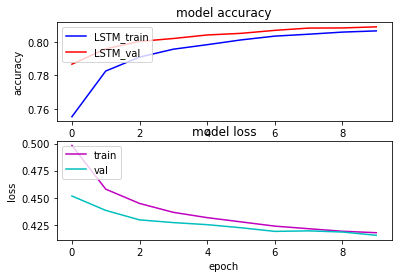

In [34]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

<a name='13'></a>
###Confusion matrix

In [35]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 5s 146ms/step


In [36]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

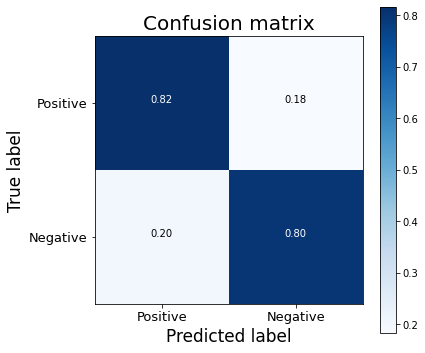

In [37]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

<a name='14'></a>
###Classification scores

In [38]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81    160336
    Positive       0.81      0.80      0.81    159664

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



<a name='15'></a>
###Saving model

In [39]:
model.save('/content/gdrive/MyDrive/NLP_Model/'+MODEL_PATH)

In [40]:
#To load it :
from tensorflow import keras
loaded_model = keras.models.load_model('/content/gdrive/MyDrive/NLP_Model/'+MODEL_PATH)

In [ ]:
#todo : display and compare all models resutls

<a name='16'></a>
#Testing our model

###Pipeline

In [65]:
def decode_sentiment_with_neutral(score):
  if score > 0.65:
    return "Positive"
  elif score < 0.45:
    return "Negative"
  else:
    return "Neutral"

In [66]:
def pipeline(text):

  text_clean = clean_data(text, True, False)

  x_test = pad_sequences(tokenizer.texts_to_sequences([text_clean]), maxlen = MAX_SEQUENCE_LENGTH)

  score = model.predict(x_test)[0]

  sentiment = decode_sentiment_with_neutral(score)

  return {"Tweet" : text, "Sentiment" : sentiment, "Score ": float(score)}

In [63]:
#Positive example
pipeline("I enjoyed working on this project")

{'Score ': 0.9156351685523987,
 'Sentiment': 'Positive',
 'Tweet': 'I enjoyed working on this project'}

In [67]:
#Negative example
pipeline("The deadline of the project was too short, we didn't have enough time")

{'Score ': 0.08768607676029205,
 'Sentiment': 'Negative',
 'Tweet': "The deadline of the project was too short, we didn't have enough time"}

In [68]:
#Neutral example
pipeline("Does anyone know where I can find a good restaurant in Paris ?")

{'Score ': 0.5973559021949768,
 'Sentiment': 'Neutral',
 'Tweet': 'Does anyone know where I can find a good restaurant in Paris ?'}

In [57]:
#Exemple where we need to improve :
pipeline("You're the king of loser")

{'Score ': 0.8872846961021423,
 'Sentiment': 'Positive',
 'Tweet': "You're the king of loser"}

In [ ]:
#todo : yelp api